# Transfer Learning with Inceptionv3 on CIFAR-10 in Keras

### Imports

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing import image
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.models import Model
from keras.layers import UpSampling2D, Flatten

### Pretrained Model loading

In [3]:
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
conv_base.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>


include_top = False , means we r going to create our own fully connected layer.

In [5]:
# printing all the layers
for layer in conv_base.layers:
  print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=conv2d, built=True>
<BatchNormalization name=batch_normalization, built=True>
<Activation name=activation, built=True>
<Conv2D name=conv2d_1, built=True>
<BatchNormalization name=batch_normalization_1, built=True>
<Activation name=activation_1, built=True>
<Conv2D name=conv2d_2, built=True>
<BatchNormalization name=batch_normalization_2, built=True>
<Activation name=activation_2, built=True>
<MaxPooling2D name=max_pooling2d, built=True>
<Conv2D name=conv2d_3, built=True>
<BatchNormalization name=batch_normalization_3, built=True>
<Activation name=activation_3, built=True>
<Conv2D name=conv2d_4, built=True>
<BatchNormalization name=batch_normalization_4, built=True>
<Activation name=activation_4, built=True>
<MaxPooling2D name=max_pooling2d_1, built=True>
<Conv2D name=conv2d_8, built=True>
<BatchNormalization name=batch_normalization_8, built=True>
<Activation name=activation_8, built=True>
<Conv2D name=conv2d_6, built=True>
<Conv2D

### Freezing Layers

In [8]:
# don't train existing weights
for layer in conv_base.layers:
    layer.trainable = False

In [9]:
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
acti

### Model Summary

In [10]:
conv_base.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

### Loading the CIFAR-10 Dataset

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Model Architecture

In [12]:
from tensorflow.keras.layers import Resizing

model = models.Sequential()

model.add(layers.UpSampling2D((2,2)))  #32*2 =64  ## UpSampling increase the row and column of the data.Sometimes if we have less data so we can try to increase the data in this way.
model.add(layers.UpSampling2D((2,2)))  #64*2 = 128
model.add(layers.UpSampling2D((2,2)))  #128*2 = 256


model.add(Resizing(224, 224, interpolation="bilinear"))
model.add(conv_base)                             ## conv_base is the inception network.We are keeping it here.

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu' ))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))


### Model Compilation & Training

In [13]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [14]:
history = model.fit(x_train, y_train, steps_per_epoch=10, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - acc: 0.1361 - loss: 6.3103 - val_acc: 0.4599 - val_loss: 1.6526
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.4979 - loss: 1.4093 - val_acc: 0.4856 - val_loss: 1.5528
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.5525 - loss: 1.2703 - val_acc: 0.6933 - val_loss: 0.9745
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.6472 - loss: 1.0721 - val_acc: 0.6853 - val_loss: 0.9635
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.6269 - loss: 1.1139 - val_acc: 0.7123 - val_loss: 0.8293
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.6545 - loss: 1.0496 - val_acc: 0.7427 - val_loss: 0.7570
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.7377 - loss: 0.8400 - val_acc: 0.5852 - val_loss: 1.3289
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.6118 - loss: 1.2107 - val_acc: 0.7086 - val_loss: 0.8651
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - acc: 0.7580 - loss: 

### Save & Load the model

In [15]:
model.save("cifar_model.h5")

In [16]:
model = tf.keras.models.load_model("cifar_model.h5")

Input Dimensions - Image :  (500, 500, 3)


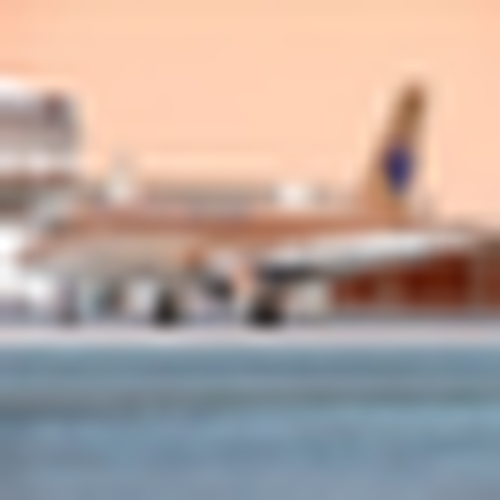

In [17]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img= "http://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png"

input_img = io.imread(input_img)
#scale up to meet the size requirements.
#If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation.
#If you are shrinking the image, you should prefer to use INTER_AREA interpolation.Cubic interpolation is computationally more complex, and hence slower than linear interpolation.
#However, the quality of the resulting image will be higher.
input_img = cv2.resize(input_img, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
cv2_imshow(input_img)

In [18]:
import numpy as np
import keras.utils as image

input_img = cv2.resize(input_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(input_img) #Converts a PIL Image instance to a Numpy array.
x = np.expand_dims(x, axis=0)     # converting into 1 dimensional array
x = preprocess_input(x)           #The preprocess_input function is meant to adequate your image to the format the model requires.
preds = model.predict(x)
class_idx = np.argmax(preds[0])

preds[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


array([9.8281485e-01, 1.1648470e-02, 5.4560113e-04, 7.7850990e-07,
       4.3331902e-08, 1.0921308e-07, 3.4320979e-06, 1.6105814e-04,
       4.6389191e-03, 1.8666385e-04], dtype=float32)

In [19]:
class_idx

0

In [ ]:
# 0 : airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck